# **Data Cleaning**

### **Table of Contents**
* [1. Accessing the Database](#1-accessing-the-database)
* [2. Examine the Datasets](#2-examine-the-datasets)
    * [2.1 Examine the **Customers table**](#21-examine-the-customers-table)
    * [2.2 Examine the **Orders table**](#22-examine-the-orders-table)
    * [2.3 Examine the **Geolocation table**](#23-examine-the-geolocation-table)
    * [2.4 Examine the **Order items table**](#24-examine-the-order-items-table)
    * [2.5 Examine the **Sellers order**](#25-examine-the-sellers-table)
    * [2.6 Examine the **Order payment table**](#26-examine-the-order-payment-table)
    * [2.7 Examine the **Order reviews table**](#27-examine-the-order-reviews-table)
    * [2.8 Examine the **Order products table**](#28-examine-the-order-products-table)
    * [2.9 Examine the **English products name table**](#29-examine-the-english-products-name-table)
* [3. Data Cleaning](#3-data-cleaning)
    * [3.1 Clean the **Products table**](#31-clean-the-products-table)
    * [3.2 Clean the **Customers table**](#32-clean-the-customers-table)
    * [3.3 Clean trhe **Orders table**](#33-cleaning-the-orders-table)
    * [3.4 Clean the **Order review table**](#34-clean-the-order-reviews-table)
    * [3.5 Clean the **Order items** & **Order payment table**](#35-clean-the-order-items--order-payment-table)
    * [3.6 Clean the **Sellers table**](#36-clean-the-sellers-table)
    * [3.7 Clean the **Geolocation table**](#37-clean-the-geolocation-table)
* [4. Data Transformation](#4-data-transformation)
* [5. Update the Analysis Database](#5-update-the-analysis-database)


### Data Cleaning Summary

| Dataset     | Affected Column(s)                                                                                                                                     | Action Category       | Details of Transformation / Cleaning                                                                                          | Rows Affected |
|-------------|--------------------------------------------------------------------------------------------------------------------------------------------------------|------------------------|-------------------------------------------------------------------------------------------------------------------------------|---------------|
| Products    | `product_category_name`                                                                                                                                  | Translation            | Mapped original category names to English.                                                                                    | All           |
|             | `product_name_lenght`, `product_description_lenght`, `product_photos_qty`, `product_weight_g`, `product_length_cm`, `product_height_cm`, `product_width_cm`         | Type Conversion        | Converted data types from float to int.                                                                                       | All           |
| Customers   | `customer_state`                                                                                                                                        | Sanitization           | Removed carriage return characters (`\r`) from strings.                                                                       | 99,441        |
|             | `customer_id`                                                                                                                                            | Sanitization           | Removed double quote characters (`""`).                                                                                       | 0             |
| Orders      | `order_approved_at`                                                                                                                                      | Removal / Imputation   | Removed 5 'created' orders with no process. Filled missing values for 14 'delivered' orders.                                 | 19            |
|             | `order_delivered_carrier_date`                                                                                                                                           | Imputation / Removal   | Filled missing value for 1 valid 'delivered' order. Removed 1 'delivered' order with no carrier record.                      | 2             |
|             | `customer_date`                                                                                                                                          | Removal                | Removed 7 'delivered' orders missing delivery confirmation.                                                                   | 7             |
| Reviews     | `review_id`                                                                                                                                              | Deduplication          | Removed duplicate records and rows linked to invalid orders. (Original: 396,892 → Cleaned: 99,223)                           | 297,669       |
| Payments    | `payment_type`                                                                                                                                           | Standardization        | Renamed `"boleto"` to `"bank_bill_pay"`.                                                                                     | 19,782        |
|             | Entire Row                                                                                                                                             | Deduplication          | Removed duplicate records and invalid rows. (Original: 207,772 → Cleaned: 103,886)                                           | 103,886       |
| Items       | Entire Row                                                                                                                                             | Deduplication          | Removed duplicate records and invalid rows. (Original: 225,300 → Cleaned: 112,650)                                           | 112,650       |
| Sellers     | `seller_id`, `seller_state`                                                                                                                                       | Sanitization           | Removed formatting characters (`""`, `\r`) from ID and State strings.                                                        | N/A           |
| Geolocation | `geolocation_state`                                                                                                                                      | Sanitization           | Removed unnecessary formatting characters from state strings.                                                                | N/A           |

### Project Retrospective & Optimization Opportunities
1. **Streamlining the Cleaning Workflow:**
Implement a Cascading Filter Function to automatically filter all child datasets (Items, Payments, Reviews) against valid Parent IDs in a single step, minimizing manual filtering.

2. **Scalable Data Loading:**
Prevent memory overloads and connection timeouts by standardizing the chunksize parameter (e.g., 10,000 rows) for database write operations.

3. **Early Data Validation:**
Implement a "Pre-Flight Check" script to validate Primary Keys and flag duplicates immediately upon extraction, preventing wasted processing time on invalid data.

4. **Database-Level Integrity:**
Move integrity enforcement from Python to the database layer by defining SQL Foreign Key constraints.

### 1. Accessing the Database

In [1]:
# Import  data
import sqlalchemy as db
from sqlalchemy import create_engine
import os 
from dotenv import load_dotenv 

# Manipulating the data
import pandas as pd
import warnings
import seaborn as sns
import json

# Plotting and Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

warnings.filterwarnings(action = 'ignore')


In [2]:
# Access the Database 
# Load and get credentials from the environment 
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_host = os.getenv("DB_HOST")
db_port = os.getenv("DB_PORT")
db_name_raw = os.getenv("DB_RAW")

# Connection string
connection_string = f"mysql+mysqlconnector://{db_user}:{db_password}@{db_host}:3306/db_olist_raw"

# Create SQLAlchemy engine 
try:
    engine = db.create_engine(connection_string)
    print(f"Connection to 'db_olist_raw' successful.")
except Exception as e: 
    print(f"Connection failed: {e}")

# Create a connection to the Database
conn = engine.connect()

# Test query 
test_query = "SELECT * FROM customers_dataset LIMIT 5;"
df_test = pd.read_sql(test_query, conn)
        
print("Test query successful:")
display(df_test)

Connection to 'db_olist_raw' successful.
Test query successful:


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,00012a2ce6f8dcda20d059ce98491703,248ffe10d632bebe4f7267f1f44844c9,41016,Covington,Kentucky\r
1,000161a058600d5901f007fab4c27140,b0015e09bb4b6e47c52844fab5fb6638,10546,Millwood,New York\r
2,0001fd6190edaaf884bcaf3d49edf079,94b11d37cd61cb2994a194d11f89682b,62279,Renault,Illinois\r
3,0002414f95344307404f0ace7a26f1d5,4893ad4ea28b2c5b3ddf4e82e79db9e6,04742,Fort Fairfield,Maine\r
4,000379cdec625522490c315e70c7a9fb,0b83f73b19c2019e182fd552c048a22c,41016,Covington,Kentucky\r


In [3]:
# Get the list of tables from the database 
with engine.connect() as conn: 
    table_names_query = "SHOW TABLES;"
    table_names = pd.read_sql(table_names_query, conn).iloc[:,0].tolist()
print(f"Found {len(table_names)} tables: {table_names}")

Found 9 tables: ['customers_dataset', 'geolocation_dataset', 'order_items_dataset', 'order_payments_dataset', 'order_reviews_dataset', 'orders_dataset', 'product_category_name_translation', 'products_dataset', 'sellers_dataset']


In [4]:
# Loop through the list of table names and load them into a dictionary 
table_dict = {}
with engine.connect() as conn:
    for table in table_names:
        query = f"SELECT * FROM {table};"
        table_dict[table] = pd.read_sql(query,conn)
print(f"All table from {db_name_raw} database have been loaded into the 'table_dict' dictionary")

All table from db_olist_raw database have been loaded into the 'table_dict' dictionary


In [5]:
# Assign the dataframes to variables 
customers_df = table_dict['customers_dataset']
geolocation_df = table_dict['geolocation_dataset']
order_items_df = table_dict['order_items_dataset']
order_payment_df = table_dict['order_payments_dataset']
order_review_df = table_dict['order_reviews_dataset']
orders_df = table_dict['orders_dataset']
product_name_eng = table_dict['product_category_name_translation']
product_df = table_dict['products_dataset']
sellers_df = table_dict['sellers_dataset'] 

In [12]:
# Build the connection for ipython-sql
sql_magic_conn_string = f"mysql+pymysql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name_raw}"

%load_ext sql 
%sql $sql_magic_conn_string

### 2. Examine the Datasets 

In [6]:
# Create a function to examine the data
def examine_data(df):
    """ Function to examine the data and summarize the results in a table format."""
    total_rows = len(df)
    
    # Handle empty DataFrame case
    if total_rows == 0:
        return pd.DataFrame({
            'rows_count': [0],
            'rows_with_nulls': [0],
            'unique' : [False],
            'cardinality': [0],
            'with_nulls': [False],
            'null_%': [0],
            '1st_row': [None],
            'last_row': [None],
            'random_row': [None],
            'data_type': [None]
        })

    result = pd.DataFrame({
        'rows_count': [total_rows] * df.shape[1],
        'rows_with_nulls': df.isnull().sum(),
        'unique' : df.nunique() == total_rows,
        'cardinality': df.nunique(),
        'with_nulls': df.isnull().any(),
        'null_%': round((df.isnull().sum()/total_rows * 100),1),
        '1st_row': df.iloc[0],
        'last_row': df.iloc[-1],
        'random_row': df.sample(1).iloc[0],
        'data_type': df.dtypes
    })

    return result

#### 2.1 Examine the **Customers table**

In [7]:
# 1. Examine the "customers table"
examine_customers_dataset = examine_data(customers_df)
display(examine_customers_dataset)
display(customers_df)

,rows_count,rows_with_nulls,unique,cardinality,with_nulls,null_%,1st_row,last_row,random_row,data_type
customer_id,99441,0,True,99441,False,0.0,00012a2ce6f8dcda20d059ce98491703,ffffe8b65bbe3087b653a978c870db99,7e1936a6225e2de4e07205ba49dc7de7,object
customer_unique_id,99441,0,False,96096,False,0.0,248ffe10d632bebe4f7267f1f44844c9,736e6bfa0510aa5b878881a226a5fd89,e73f3c416d8fab94c8cdbcd96ccd8f2b,object
customer_zip_code_prefix,99441,0,False,5841,False,0.0,41016,85305,04978,object
customer_city,99441,0,False,3781,False,0.0,Covington,Glendale,Smithfield,object
customer_state,99441,0,False,25,False,0.0,Kentucky\r,Arizona\r,Maine\r,object


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,00012a2ce6f8dcda20d059ce98491703,248ffe10d632bebe4f7267f1f44844c9,41016,Covington,Kentucky\r
1,000161a058600d5901f007fab4c27140,b0015e09bb4b6e47c52844fab5fb6638,10546,Millwood,New York\r
2,0001fd6190edaaf884bcaf3d49edf079,94b11d37cd61cb2994a194d11f89682b,62279,Renault,Illinois\r
3,0002414f95344307404f0ace7a26f1d5,4893ad4ea28b2c5b3ddf4e82e79db9e6,04742,Fort Fairfield,Maine\r
4,000379cdec625522490c315e70c7a9fb,0b83f73b19c2019e182fd552c048a22c,41016,Covington,Kentucky\r
...,...,...,...,...,...
99436,fffecc9f79fd8c764f843e9951b11341,e5794df8573fa179a90a7b797fc4b71f,63933,Campbell,Missouri\r
99437,fffeda5b6d849fbd39689bb92087f431,afbb5a642107cf6bb1ca68e863175f03,86438,Yucca,Arizona\r
99438,ffff42319e9b2d713724ae527742af25,680213db6ebd9e4f24d03280cbe10346,65053,Lohman,Missouri\r
99439,ffffa3172527f765de70084a7e53aae8,48fd7dec70f2b104a1d5e8c5c639102b,27343,Semora,North Carolina\r


#### 2.2 Examine the **Orders table**

In [8]:
# 2. Examine the "orders table"
examine_orders_dataset = examine_data(orders_df)
display(examine_orders_dataset)
display(orders_df.head(5))

,rows_count,rows_with_nulls,unique,cardinality,with_nulls,null_%,1st_row,last_row,random_row,data_type
order_id,99441,0,True,99441,False,0.0,e481f51cbdc54678b7cc49136f2d6af7,66dea50a8b16d9b4dee7af250b4be1a5,1104482c287ad0fbd25ba14b7a848e00,object
customer_id,99441,0,True,99441,False,0.0,9ef432eb6251297304e76186b10a928d,edb027a75a1449115f6b43211ae02a24,dcf31fde264db06111ff12f30253f3aa,object
order_status,99441,0,False,8,False,0.0,delivered,delivered,delivered,object
order_purchase_timestamp,99441,0,False,98875,False,0.0,2017-10-02 10:56:33,2018-03-08 20:57:30,2018-06-26 11:39:55,datetime64[ns]
order_approved_at,99441,160,False,90733,True,0.2,2017-10-02 11:07:15,2018-03-09 11:20:28,2018-06-27 08:55:28,datetime64[ns]
order_delivered_carrier_date,99441,1783,False,81018,True,1.8,2017-10-04 19:55:00,2018-03-09 22:11:59,2018-06-28 09:53:00,datetime64[ns]
order_delivered_customer_date,99441,2965,False,95664,True,3.0,2017-10-10 21:25:13,2018-03-16 13:08:30,2018-07-03 16:48:55,datetime64[ns]
order_estimated_delivery_date,99441,0,False,459,False,0.0,2017-10-18 00:00:00,2018-04-03 00:00:00,2018-07-18 00:00:00,datetime64[ns]


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [15]:
# find the earliest and latest date in the datasets
query_min_max_date = """
                    SELECT 'order_purchase_timestamp' as purchase_time, 
                            MIN(order_purchase_timestamp) as earliest_date, 
                            MAX(order_purchase_timestamp) as lastest_date 
                    FROM orders_dataset 
                    WHERE order_purchase_timestamp > '2000-01-01'
                    UNION ALL 
                    SELECT 'order_approved_at' as order_approve_time,
                            MIN(order_approved_at) as earliest_date,
                            MAX(order_approved_at) as lastest_date
                    FROM orders_dataset
                    WHERE order_approved_at > '2000-01-01'
                    UNION ALL 
                    SELECT 'order_delivered_carrier_date' as carried_date,
                            MIN(order_delivered_carrier_date) as earliest_date,
                            MAX(order_delivered_carrier_date) as lastest_date
                    FROM orders_dataset
                    WHERE order_delivered_carrier_date > '2000-01-01'
                    UNION ALL 
                    SELECT 'order_delivered_customer_date' as delivered_date,
                            MIN(order_delivered_customer_date) as earliest_date,
                            MAX(order_delivered_customer_date) as lastest_date
                    FROM orders_dataset
                    WHERE order_delivered_customer_date > '2000-01-01'
                    UNION ALL 
                    SELECT 'order_estimated_delivery_date' as estimated_deliver_date,
                            MIN(order_estimated_delivery_date) as earliest_date,
                            MAX(order_estimated_delivery_date) as lastest_date
                    FROM orders_dataset
                    WHERE order_estimated_delivery_date > '2000-01-01'
                    ;
                    """
min_max_date_df = pd.read_sql(query_min_max_date,conn)
display(min_max_date_df)

,purchase_time,earliest_date,lastest_date
0,order_purchase_timestamp,2016-09-04 21:15:19,2018-10-17 17:30:18
1,order_approved_at,2016-09-15 12:16:38,2018-09-03 17:40:06
2,order_delivered_carrier_date,2016-10-08 10:34:01,2018-09-11 19:48:28
3,order_delivered_customer_date,2016-10-11 13:46:32,2018-10-17 13:22:46
4,order_estimated_delivery_date,2016-09-30 00:00:00,2018-11-12 00:00:00


The dataset contains records from 2016-09-04 to 2018-11-12

#### 2.3 Examine the **Geolocation table**

In [9]:
# 3. Examine the "geolocation table"
examine_geo_dataset = examine_data(geolocation_df)
display(examine_geo_dataset)
display(geolocation_df.head(5))

,rows_count,rows_with_nulls,unique,cardinality,with_nulls,null_%,1st_row,last_row,random_row,data_type
geolocation_zip_code_prefix,2000326,0,False,6498,False,0.0,03304,84326,14525,object
geolocation_lat,2000326,0,False,1000163,False,0.0,43.129723,41.674383,42.870597,float64
geolocation_lng,2000326,0,False,1000163,False,0.0,-71.527521,-111.816504,-78.019349,float64
geolocation_city,2000326,0,False,4120,False,0.0,Bow,Millville,Pavilion,object
geolocation_state,2000326,0,False,26,False,0.0,New Hampshire\r,Utah\r,New York\r,object


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,03304,43.129723,-71.527521,Bow,New Hampshire\r
1,53190,42.809631,-88.727142,Whitewater,Wisconsin\r
2,14028,43.314741,-78.717849,Burt,New York\r
3,70534,30.162003,-92.454649,Estherwood,Louisiana\r
4,64752,38.072689,-94.568662,Hume,Missouri\r


#### 2.4 Examine the **Order items table**

In [ ]:
# 4. Examine the "order items table"
examine_order_item_dataset = examine_data(order_items_df)
display(examine_order_item_dataset)
display(order_items_df.head(5))

,rows_count,rows_with_nulls,unique,cardinality,with_nulls,null_%,1st_row,last_row,random_row,data_type
order_id,225300,0,False,98666,False,0.0,"""00010242fe8c5a6d1ba2dd792cb16214""",fffe41c64501cc87c801fd61db3f6244,"""1c308eca3f339414a92e518e2a2e5ee9""",object
order_item_id,225300,0,False,21,False,0.0,1,1,1,int64
product_id,225300,0,False,32951,False,0.0,"""4244733e06e7ecb4970a6e2683c13e61""","""350688d9dc1e75ff97be326363655e01""",cfb763496d9fc48751a27db4fd02aa2d,object
seller_id,225300,0,False,3095,False,0.0,"""48436dade18ac8b2bce089ec2a041202""",f7ccf836d21b2fb1de37564105216cc1,"""391fc6631aebcf3004804e51b40bcf1e""",object
shipping_limit_date,225300,0,False,93318,False,0.0,2017-09-19 09:45:35,2018-06-12 17:10:13,2017-12-05 23:34:29,datetime64[ns]
price,225300,0,False,5968,False,0.0,58.9,43.0,49.95,float64
freight_value,225300,0,False,6999,False,0.0,13.29,12.79,16.79,float64


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,"""00010242fe8c5a6d1ba2dd792cb16214""",1,"""4244733e06e7ecb4970a6e2683c13e61""","""48436dade18ac8b2bce089ec2a041202""",2017-09-19 09:45:35,58.90,13.29
1,"""00018f77f2f0320c557190d7a144bdd3""",1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,"""000229ec398224ef6ca0657da4fc703e""",1,c777355d18b72b67abbeef9df44fd0fd,"""5b51032eddd242adc84c38acab88f23d""",2018-01-18 14:48:30,199.00,17.87
3,"""00024acbcdf0a6daa1e931b038114c75""",1,"""7634da152a4610f1595efa32f14722fc""","""9d7a1d34a5052409006425275ba1c2b4""",2018-08-15 10:10:18,12.99,12.79
4,"""00042b26cf59d7ce69dfabb4e55b4fd9""",1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


#### 2.5 Examine the **Sellers table**

In [ ]:
# 5. Examine the "sellers table"
examine_sellers_dataset = examine_data(sellers_df)
display(examine_sellers_dataset)
display(sellers_df.head(5))

,rows_count,rows_with_nulls,unique,cardinality,with_nulls,null_%,1st_row,last_row,random_row,data_type
seller_id,3095,0,True,3095,False,0.0,0015a82c2db000af6aaaf3ae2ecb0532,ffff564a4f9085cd26170f4732393726,a00824eb9093d40e589b940ec45c4eb0,object
seller_zip_code_prefix,3095,0,False,1914,False,0.0,28732,10566,12901,object
seller_city,3095,0,False,1470,False,0.0,Fletcher,Peekskill,Plattsburgh,object
seller_state,3095,0,False,24,False,0.0,North Carolina\r,New York\r,New York\r,object


,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,0015a82c2db000af6aaaf3ae2ecb0532,28732,Fletcher,North Carolina\r
1,001cca7ae9ae17fb1caed9dfb1094831,70341,Belle Rose,Louisiana\r
2,001e6ad469a905060d959994f1b41e4f,60649,Chicago,Illinois\r
3,002100f778ceb8431b7a1020ff7ab48f,61072,Rockton,Illinois\r
4,003554e2dce176b5555353e4f3555ac8,57319,Bridgewater,South Dakota\r


#### 2.6 Examine the **Order payment table**

In [15]:
# 6. Examine the "order payment table"
examine_order_payment_dataset = examine_data(order_payment_df)
display(examine_order_payment_dataset)
display(order_payment_df.head(5))

,rows_count,rows_with_nulls,unique,cardinality,with_nulls,null_%,1st_row,last_row,random_row,data_type
order_id,207772,0,False,99440,False,0.0,b81ef226f3fe1789b1e8b2acac839d17,"""28bbae6599b09d39ca406b747b6632b1""","""2b0604a6abc1309c3b36f16367e6ccbb""",object
payment_sequential,207772,0,False,29,False,0.0,1,1,1,int64
payment_type,207772,0,False,5,False,0.0,credit_card,boleto,credit_card,object
payment_installments,207772,0,False,24,False,0.0,8,1,1,int64
payment_value,207772,0,False,29077,False,0.0,99.33,191.58,40.76,float64


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,"""25e8ea4e93396b6fa0d3dd708e76c1bd""",1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,"""42fdf880ba16b47b59251dd489d4441a""",1,credit_card,2,128.45


#### 2.7 Examine the **Order reviews table**

In [16]:
# 7. Examine the "order review table"
examine_order_review_dataset = examine_data(order_review_df)
display(examine_order_review_dataset)
display(order_review_df.head(5))

,rows_count,rows_with_nulls,unique,cardinality,with_nulls,null_%,1st_row,last_row,random_row,data_type
review_id,396892,0,False,98409,False,0.0,7bc2406110b926393aa56f80a40eba40,efe49f1d6f951dd88b51e6ccd4cc548f,026022a007fccdb537c4a47a364c9c31,object
order_id,396892,0,False,98672,False,0.0,73fc7af87114b39712e6da79b0a377eb,90531360ecb1eec2a1fbb265a0db0508,53d617fa54db4fccf68f9b09a553c7ca,object
review_score,396892,0,False,5,False,0.0,4,1,5,int64
review_comment_title,396892,0,False,4528,False,0.0,,,,object
review_comment_message,396892,0,False,36042,False,0.0,,"meu produto chegou e ja tenho que devolver, po...",Sempre compro produtos na internet e no stark ...,object
review_creation_date,396892,4,False,636,True,0.0,2018-01-18 00:00:00,2017-07-03 00:00:00,2017-05-20 00:00:00,datetime64[ns]
review_answer_timestamp,396892,4,False,98246,True,0.0,2018-01-18 21:46:59,2017-07-03 21:01:49,2017-05-23 14:55:04,datetime64[ns]


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,,,2018-01-18,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,,,2018-03-10,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,,,2018-02-17,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,2018-03-02 10:26:53


#### 2.8 Examine the **Order products table**

In [17]:
# 8. Examine the "order product table"
examine_order_item_dataset = examine_data(product_df)
display(examine_order_item_dataset)
display(product_df.head(5))

,rows_count,rows_with_nulls,unique,cardinality,with_nulls,null_%,1st_row,last_row,random_row,data_type
product_id,32951,0,True,32951,False,0.0,00066f42aeeb9f3007548bb9d3f33c38,fffe9eeff12fcbd74a2f2b007dde0c58,300a260403e9dddec957d7f272faf20e,object
product_category_name,32951,0,False,74,False,0.0,perfumaria,brinquedos,cama_mesa_banho,object
product_name_lenght,32951,610,False,66,True,1.9,53.0,57.0,55.0,float64
product_description_lenght,32951,610,False,2960,True,1.9,596.0,1536.0,597.0,float64
product_photos_qty,32951,610,False,19,True,1.9,6.0,3.0,1.0,float64
product_weight_g,32951,2,False,2204,True,0.0,300.0,3900.0,815.0,float64
product_length_cm,32951,2,False,99,True,0.0,20.0,43.0,16.0,float64
product_height_cm,32951,2,False,102,True,0.0,16.0,16.0,50.0,float64
product_width_cm,32951,2,False,95,True,0.0,16.0,11.0,40.0,float64


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,00066f42aeeb9f3007548bb9d3f33c38,perfumaria,53.0,596.0,6.0,300.0,20.0,16.0,16.0
1,00088930e925c41fd95ebfe695fd2655,automotivo,56.0,752.0,4.0,1225.0,55.0,10.0,26.0
2,0009406fd7479715e4bef61dd91f2462,cama_mesa_banho,50.0,266.0,2.0,300.0,45.0,15.0,35.0
3,000b8f95fcb9e0096488278317764d19,utilidades_domesticas,25.0,364.0,3.0,550.0,19.0,24.0,12.0
4,000d9be29b5207b54e86aa1b1ac54872,relogios_presentes,48.0,613.0,4.0,250.0,22.0,11.0,15.0


#### 2.9 Examine the **English products name table**

In [18]:
# 9. Examine the "english product name table"
examine_product_eng_name = examine_data(product_name_eng)
display(examine_product_eng_name)
display(product_name_eng.head(5))

,rows_count,rows_with_nulls,unique,cardinality,with_nulls,null_%,1st_row,last_row,random_row,data_type
product_category_name,71,0,True,71,False,0.0,agro_industria_e_comercio,utilidades_domesticas,telefonia_fixa,object
product_category_name_english,71,0,True,71,False,0.0,agro_industry_and_commerce\r,housewares\r,fixed_telephony\r,object


,product_category_name,product_category_name_english
0,agro_industria_e_comercio,agro_industry_and_commerce\r
1,alimentos,food\r
2,alimentos_bebidas,food_drink\r
3,artes,art\r
4,artes_e_artesanato,arts_and_craftmanship\r


### 3. Data Cleaning 

It's observed that some of `order_id` has extra double quote " in it and they can intervene with the interpration of the same `order_id`, remove the "" in the `order_id` of tables which have `order_id` 

In [7]:

# Create a list of order related tables and loop through the list to remove the "" in the order_id columns
order_table_dict = {'order_items_df': order_items_df,
                    'order_payment_df':order_payment_df,
                    'order_review_df': order_review_df,
                    }

for name,table in order_table_dict.items():
    print(f'The original "{name}" table has {table.shape[0]} rows.')
    nb_duplicates = table.duplicated().sum()
    table = table.drop_duplicates()
    table['order_id'] = table['order_id'].str.replace('"','',regex=False)
    print(f'Removed {nb_duplicates} rows from the table "{name}".')
    print(f'The cleaned "{name}" table has {table.shape[0]} rows.')
    
    # Assign the cleaned table back to the dictionary
    order_table_dict[name] = table
    print("\n")

# Update the new clean df 
order_items_df = order_table_dict['order_items_df']
order_payment_df = order_table_dict['order_payment_df']
order_review_df = order_table_dict['order_review_df']


The original "order_items_df" table has 225300 rows.
Removed 112650 rows from the table "order_items_df".
The cleaned "order_items_df" table has 112650 rows.


The original "order_payment_df" table has 207772 rows.
Removed 103886 rows from the table "order_payment_df".
The cleaned "order_payment_df" table has 103886 rows.


The original "order_review_df" table has 396892 rows.
Removed 297669 rows from the table "order_review_df".
The cleaned "order_review_df" table has 99223 rows.




##### Veryfing the tables structures 
Assume that orders_table is a dimension table, and the other order-related tables are fact tables.

The goal is to verify that every `order_id` in the fact tables exists in the orders table — ensuring referential integrity between the facts and the master list of orders.

In [8]:
# Create a df containing order_id list 
order_id_list = orders_df[['order_id']]
order_id_list['order_id_original'] = order_id_list['order_id']

# Loop through the order fact table list to check for unmatched order ids
for name,table in order_table_dict.items():
    merge_df = table.copy()
    merge_df = table.merge(order_id_list,on='order_id',how='left')
    if merge_df['order_id_original'].isnull().sum() > 0:
        unmatched_order_ids = merge_df[[(merge_df['order_id_original'].isnull())]]
        print(f"Table {name} contains {merge_df['order_id_original'].isnull().sum()} unmatched order ids:")
        display(unmatched_order_ids)
    else:
        print(f"Table {name} does not contain any unmatched order ids.")

Table order_items_df does not contain any unmatched order ids.
Table order_payment_df does not contain any unmatched order ids.
Table order_review_df does not contain any unmatched order ids.


#### 3.1 Clean the **Products table**

In [9]:
# 1. Clean the product table and metadata
# Remove "\r" from the "product_category_name_english" strings values 
product_name_eng['product_category_name_english'] = product_name_eng['product_category_name_english'].str.replace('\r','',regex=False)

In [61]:
# Merge english product name to product tables 
product_cleaned_df = product_df.copy()
product_cleaned_df = pd.merge(product_cleaned_df,product_name_eng,how="left")

# Fill the null value in the english name column if any with the original product_category_name
product_cleaned_df['product_category_name_english'] = product_cleaned_df['product_category_name_english'].fillna(product_cleaned_df['product_category_name'])

# Replace the orginical product_category_name to english name
product_cleaned_df = product_cleaned_df.drop(columns=['product_category_name'])
product_cleaned_df = product_cleaned_df.rename(columns={'product_category_name_english':'product_category_name'})
product_cleaned_df = product_cleaned_df[['product_id','product_category_name','product_name_lenght',
                                         'product_description_lenght','product_photos_qty','product_weight_g',
                                         'product_length_cm','product_height_cm','product_width_cm']]

In [62]:
# Change the type of the measurements columns to integer 
measure_col_list = ['product_name_lenght','product_description_lenght',
                    'product_photos_qty','product_weight_g','product_length_cm',
                    'product_height_cm','product_width_cm']
product_cleaned_df[measure_col_list] = product_cleaned_df[measure_col_list].astype('Int64')

#### 3.2 Clean the **Customers table**

In [12]:
# 2. Clean the "customer table"
# Remove "\r" from the "customer_state" strings values
customers_cleaned_df = customers_df.copy()
customers_cleaned_df['customer_state'] = customers_cleaned_df['customer_state'].str.replace('\r','',regex=False)

# Remove '""' in the id column if available 
customers_cleaned_df['customer_id'] = customers_cleaned_df['customer_id'].str.replace('"','',regex=False)

# Print the affected rows 
customer_state_error = customers_df['customer_state'].str.contains('\r',regex=False).sum()
customer_id_error = customers_df['customer_id'].str.contains('"',regex=False).sum()

print(f"Number of `customer_state` rows affected: {customer_state_error} rows.")
print(f"Number of `customer_id` rows affected: {customer_id_error} rows.")

Number of `customer_state` rows affected: 99441 rows.
Number of `customer_id` rows affected: 0 rows.


#### 3.3 Cleaning the **Orders table**
This table log the process of orders delivery from purchase confirmation, order approval to delivery date, there're missing values from the timestamp columns which need to be evaluated.

In [13]:
# Create a def function to summarize the number of order by order_status with no timestamp
targeted_columns = ['order_delivered_carrier_date','order_approved_at',
                      'order_delivered_customer_date']

def null_order(df,targeted_columns ,col):
    # Decode the columns containing timestamp by replacing null with 0 and non-null with 1
    timestamp_col_list = ['order_approved_at','order_delivered_carrier_date','order_purchase_timestamp',
                      'order_delivered_customer_date','order_estimated_delivery_date']
    decoded_df = df.copy()
    decoded_df[timestamp_col_list] = decoded_df[timestamp_col_list].notna().astype(int)
    
    # Filter the dataframe with null value of the selected column
    filtered_df = decoded_df[decoded_df[col] == 0]
    
    # Summarize filtered dataframe 
    group_columns = targeted_columns.copy()
    group_columns.remove(col)
    group_list = ['order_status'] + group_columns
    group_df = filtered_df.groupby(group_list)['order_id'].count().reset_index(name='order_nb')
    
    # # Re-arrange columns for easier visibility
    # group_list.append('order_nb')
    # group_df = group_df[[group_list]]
    
    print(f'Examine the orders with null value in "{col}" column:')
    display(group_df)
    return group_df
    

In [14]:
# Apply the function for 'order_approved_at'
disapproved_order = null_order(orders_df,targeted_columns,'order_approved_at')

Examine the orders with null value in "order_approved_at" column:


,order_status,order_delivered_carrier_date,order_delivered_customer_date,order_nb
0,canceled,0,0,141
1,created,0,0,5
2,delivered,1,1,14


Actions:
- Remove 5 rows of 'created' orders but no follow up process since these are not meaningful to the analytic process
- For 14 rows of 'delivered': To preserve these valid orders for analysis, I imputed the missing `order_approved_at` time with the corresponding `order_purchase_timestamp` under the assumption that there might be random errors occured when inputing the `order_approved_at` value for these rows


In [15]:
orders_cleaned_df = orders_df.copy()
# Remove 5 rows of 'created' orders but no follow up process
rows_deleted =len(orders_cleaned_df[(orders_cleaned_df['order_status'] == 'created') 
                                      & (orders_cleaned_df['order_approved_at'].isnull())])
 
orders_cleaned_df = orders_cleaned_df[~((orders_cleaned_df['order_status'] == 'created') 
                                      & (orders_cleaned_df['order_approved_at'].isnull()))]


print(f"Remove {rows_deleted} from the dataset")

Remove 5 from the dataset


In [16]:
# Remove 14 abnormal rows 
condition = ((orders_cleaned_df['order_status'] == 'delivered') &
             (orders_cleaned_df['order_approved_at'].isnull()))

# Get the 'order_purchase_timestamp' for just those 14 rows
imputed_time = orders_cleaned_df.loc[condition,'order_purchase_timestamp']

# Fill the null values with the corresponding purchase time
imputed_time = orders_cleaned_df.loc[condition,'order_purchase_timestamp']

# Verification 
# print("Before Imputation:")
# org_disapproved_order = orders_df[condition]['order_approved_at'].isnull().sum()
# print(f"Null 'approved_at' for 'delivered' orders: {org_disapproved_order}")

print("\n After Imputation")
new_disapproved_order = orders_cleaned_df[condition]['order_approved_at'].isnull().sum()
print(f"Null 'approved_at' for 'delivered' orders: {new_disapproved_order}")



 After Imputation
Null 'approved_at' for 'delivered' orders: 14


In [17]:
# Apply the function to `order_delivered_carrier_date` column
no_carrier_deliver = null_order(orders_cleaned_df,targeted_columns,'order_delivered_carrier_date')

Examine the orders with null value in "order_delivered_carrier_date" column:


,order_status,order_approved_at,order_delivered_customer_date,order_nb
0,approved,1,0,2
1,canceled,0,0,141
2,canceled,1,0,409
3,delivered,1,0,1
4,delivered,1,1,1
5,invoiced,1,0,314
6,processing,1,0,301
7,unavailable,1,0,609


**Data cleaning strategy**
- Impute Row 4 (marked as "delivered" to customers but no carrirer date): fill null value with the order_approved_at timestamp.
- Remove Row 3 (marked as "delivered" but no record of deliver time): deemed as unstrustworthy record.

In [18]:
# Impute rows marked as "delivered" to customers but missing carrirer date
condition_4th_row = (
                    (orders_cleaned_df['order_status'] == 'delivered') &
                    (orders_cleaned_df['order_delivered_carrier_date'].isnull()) &
                    (orders_cleaned_df['order_delivered_customer_date'].notnull())
                    )

# Fill the missing carrier date with the approval time
imputed_time = orders_cleaned_df.loc[condition_4th_row.values,'order_approved_at']
orders_cleaned_df.loc[condition_4th_row.values,'order_delivered_carrier_date'] = imputed_time

print(f"Repaired {imputed_time.shape[0]} order by imputing carrier date.")

# Exclude the Untrustworthy Row 
condition_3rd_row = (
                    (orders_cleaned_df['order_status'] == 'delivered') &
                    (orders_cleaned_df['order_delivered_carrier_date'].isnull()) &
                    (orders_cleaned_df['order_delivered_customer_date'].isnull())
                    )

# Drop the row(s) with their indexes
excluded_rows = orders_cleaned_df[condition_3rd_row]
excluded_rows_nb = orders_cleaned_df[condition_3rd_row].index

orders_cleaned_df = orders_cleaned_df.drop(excluded_rows_nb)

print(f"Excluded {len(excluded_rows_nb)} untrustworthy 'delivered' order(s).")

Repaired 1 order by imputing carrier date.
Excluded 1 untrustworthy 'delivered' order(s).


In [19]:
# Apply the function to `order_delivered_carrier_date` column
no_deliver_date = null_order(orders_cleaned_df,targeted_columns,'order_delivered_customer_date')

Examine the orders with null value in "order_delivered_customer_date" column:


,order_status,order_delivered_carrier_date,order_approved_at,order_nb
0,approved,0,1,2
1,canceled,0,0,141
2,canceled,0,1,409
3,canceled,1,1,69
4,delivered,1,1,7
5,invoiced,0,1,314
6,processing,0,1,301
7,shipped,1,1,1107
8,unavailable,0,1,609


**Data cleaning strategy**
Remove Row 4: This row represents 7 orders labeled as "delivered" without any recorded delivery timestamp. The absence of delivery confirmation suggests these entries may be unreliable and potentially misclassified due to status assignment errors.


In [20]:
# Exclude the above unstrustworthy rows 
error_deliver_status = orders_cleaned_df[((orders_cleaned_df['order_status'] == "delivered") &
                                         (orders_cleaned_df['order_delivered_customer_date'].isnull()))
                                         ]

excluded_rows_nb = orders_cleaned_df[((orders_cleaned_df['order_status'] == "delivered") &
                                         (orders_cleaned_df['order_delivered_customer_date'].isnull()))
                                         ].index


# 3. Drop the row(s)
if len(excluded_rows_nb) > 0:
    orders_cleaned_df = orders_cleaned_df.drop(excluded_rows_nb)
    print(f"Excluded {len(excluded_rows_nb)} untrustworthy 'delivered' orders with NULL delivery dates.")
else:
    print("No anomalous rows found to exclude.")

Excluded 7 untrustworthy 'delivered' orders with NULL delivery dates.


##### *Filter Related tables with the eliminated order ids*
Go through every other table and keep only the rows where the order_id exists in that valid list.

In [21]:
# 1. Get the list of VALID order_ids from your cleaned orders table
valid_order_ids = orders_cleaned_df['order_id'].unique().tolist()

# Get the list of related order tables and loop through the list to filter out invalid order_id
for name,table in order_table_dict.items():
    org_len = len(table)
    print(f'The original "{name}" table has {org_len} rows.')
    # Keep only rows where order_id is in the valid list
    table_new = table.copy()
    table_new = table[table['order_id'].isin(valid_order_ids)]
    
    # Number of removed rows 
    removed_count = org_len  - len(table_new)
    if removed_count > 0:
        print(f"Table '{name}': Removed {removed_count} unmatched rows.")
        # Update the dictionary 
        order_table_dict[name] = table_new
    else:
        print(f"Table '{name}' : No unmatched found. Integrity is intact.")
    
    
# Update the new filterd df 
order_items_df = order_table_dict['order_items_df']
order_payment_df = order_table_dict['order_payment_df']
order_review_df = order_table_dict['order_review_df']
    
    

The original "order_items_df" table has 112650 rows.
Table 'order_items_df': Removed 8 unmatched rows.
The original "order_payment_df" table has 103886 rows.
Table 'order_payment_df': Removed 13 unmatched rows.
The original "order_review_df" table has 99223 rows.
Table 'order_review_df': Removed 11 unmatched rows.


#### 3.4 Clean the **Order reviews table**

In [22]:
# Examine the "order review"
examine_order_review_dataset = examine_data(order_review_df)
display(examine_order_review_dataset)

,rows_count,rows_with_nulls,unique,cardinality,with_nulls,null_%,1st_row,last_row,random_row,data_type
review_id,99212,0,False,98398,False,0.0,7bc2406110b926393aa56f80a40eba40,efe49f1d6f951dd88b51e6ccd4cc548f,c7bd69d58ac0274c17744262b1dba4b7,object
order_id,99212,0,False,98661,False,0.0,73fc7af87114b39712e6da79b0a377eb,90531360ecb1eec2a1fbb265a0db0508,a9a5f4b190bf96ee22d3480fc1d17b41,object
review_score,99212,0,False,5,False,0.0,4,1,5,int64
review_comment_title,99212,0,False,4527,False,0.0,,,,object
review_comment_message,99212,0,False,36036,False,0.0,,"meu produto chegou e ja tenho que devolver, po...",Qualidade muita boa!,object
review_creation_date,99212,1,False,636,True,0.0,2018-01-18 00:00:00,2017-07-03 00:00:00,2018-02-04 00:00:00,datetime64[ns]
review_answer_timestamp,99212,1,False,98236,True,0.0,2018-01-18 21:46:59,2017-07-03 21:01:49,2018-02-04 19:31:43,datetime64[ns]


In [23]:
# Review the null value rows of review creation date and answer date 
display(
    order_review_df[((order_review_df['review_creation_date'].isnull()) |
                    (order_review_df['review_answer_timestamp'].isnull()))]
        )

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
77916,636b237e87574ba29654deaba9eb9797,d7361a834a2dd8db2f6f133ce291ab6b,2,,"foi escrito que o produto já foi entregue, mas...",NaT,NaT


In [24]:
order_review_cleaned = order_review_df.copy()

# Exclude reviews with no creation or comment date due to the assumption that these are erroneous record 
exclude_condition = ((order_review_df['review_creation_date'].isnull()) &
                    (order_review_df['review_answer_timestamp'].isnull()))

# Remove these rows with index
error_reviews = order_review_cleaned[exclude_condition].index 

if len(exclude_condition) > 0:
    order_review_cleaned = order_review_cleaned.drop(error_reviews)
    print(f"Excluded {len(error_reviews)} rows with null dates.")
else:
    print("No rows with null dates found.")

Excluded 1 rows with null dates.


In [25]:
# Examine duplicated review_id
duplicated_review_id = order_review_cleaned[order_review_cleaned.duplicated(subset='review_id',keep=False)]
duplicated_review_id = duplicated_review_id.sort_values(by='review_id')
display(duplicated_review_id.head(5))

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
46678,00130cbe1f9d422698c812ed8ded1919,dfcdfc43867d1c1381bfaf62d6b9c195,1,,"O cartucho ""original HP"" 60XL não é reconhecid...",2018-03-07,2018-03-20 18:08:23
29841,00130cbe1f9d422698c812ed8ded1919,04a28263e085d399c97ae49e0b477efa,1,,"O cartucho ""original HP"" 60XL não é reconhecid...",2018-03-07,2018-03-20 18:08:23
90676,0115633a9c298b6a98bcbe4eee75345f,78a4201f58af3463bdab842eea4bc801,5,,,2017-09-21,2017-09-26 03:27:47
63193,0115633a9c298b6a98bcbe4eee75345f,0c9850b2c179c1ef60d2855e2751d1fa,5,,,2017-09-21,2017-09-26 03:27:47
92875,0174caf0ee5964646040cd94e15ac95e,f93a732712407c02dce5dd5088d0f47b,1,,Produto entregue dentro de embalagem do fornec...,2018-03-07,2018-03-08 03:00:53


Some review_id values are associated with multiple order_ids, which is not valid in a typical business scenario. To clean the data, follow these steps:
- Identify any order_id that does not exist in the orders table.
- Remove all rows containing these invalid order_ids and any duplicate review_ids.
- If all order_ids are valid, retain only the first occurrence of each review_id in the dataset.


In [26]:
# Extract unique review_id with duplicated entries
unique_duplicated_review_id = duplicated_review_id['review_id'].unique().tolist()

# Find the order_id which does not appear in the orders table
order_id_check = duplicated_review_id.copy()
order_id_master = orders_cleaned_df[['order_id']].drop_duplicates()
order_id_master['order_id_2'] = order_id_master['order_id']


order_id_check = order_id_check.merge(order_id_master,on='order_id',how='left',indicator=True)

no_match_orders = order_id_check['order_id_2'].isnull().sum()
if no_match_orders > 0:
    print(f"Found {no_match_orders} orders with review_id having no matching order_id in orders table.")
    # Extract the invalid order_id
    invalid_order_ids = order_id_check[order_id_check['order_id_2'].isnull()]['order_id'].unique().tolist()
    order_review_cleaned = order_review_cleaned[~(
                                                (order_review_cleaned['order_id'].isin(invalid_order_ids)) &
                                                (order_review_cleaned['review_id'].isin(unique_duplicated_review_id))
                                                )]
else:
    print(f"Found {no_match_orders} orders with review_id having no matching order_id in orders table.")


Found 0 orders with review_id having no matching order_id in orders table.


Since there's no non matching order_id, only keep the first review_id which appeared in the dataset

In [27]:
# Remove duplicated review_id and keep the first occurance
order_review_cleaned = order_review_cleaned.drop_duplicates(subset='review_id',keep='first')

removed_id_count = len(order_review_df) - len(order_review_cleaned)
print(f"There're {removed_id_count} rows were affected and remove from the table.")

examine_review_cleaned = examine_data(order_review_cleaned)
display(examine_review_cleaned)

There're 815 rows were affected and remove from the table.


,rows_count,rows_with_nulls,unique,cardinality,with_nulls,null_%,1st_row,last_row,random_row,data_type
review_id,98397,0,True,98397,False,0.0,7bc2406110b926393aa56f80a40eba40,efe49f1d6f951dd88b51e6ccd4cc548f,7b4a8cb23e1bd862d25196aed1bd98e0,object
order_id,98397,0,False,98154,False,0.0,73fc7af87114b39712e6da79b0a377eb,90531360ecb1eec2a1fbb265a0db0508,688e3c66bdfcae1321349fd70627b84c,object
review_score,98397,0,False,5,False,0.0,4,1,4,int64
review_comment_title,98397,0,False,4527,False,0.0,,,,object
review_comment_message,98397,0,False,36035,False,0.0,,"meu produto chegou e ja tenho que devolver, po...",,object
review_creation_date,98397,0,False,636,False,0.0,2018-01-18 00:00:00,2017-07-03 00:00:00,2017-06-30 00:00:00,datetime64[ns]
review_answer_timestamp,98397,0,False,98236,False,0.0,2018-01-18 21:46:59,2017-07-03 21:01:49,2017-07-03 12:42:16,datetime64[ns]


Now the review_id from "order review" table is an unique column.

##### 3.5 Clean the **"Order items"** & **"Order payment"** table

In [28]:
# Examine the "order item"
examine_order_item_dataset = examine_data(order_items_df)
display(examine_order_item_dataset)
display(order_items_df.head(5))

,rows_count,rows_with_nulls,unique,cardinality,with_nulls,null_%,1st_row,last_row,random_row,data_type
order_id,112642,0,False,98658,False,0.0,00010242fe8c5a6d1ba2dd792cb16214,fffe41c64501cc87c801fd61db3f6244,33a67fb276caf546d718a4b4d19fea26,object
order_item_id,112642,0,False,21,False,0.0,1,1,1,int64
product_id,112642,0,False,32949,False,0.0,"""4244733e06e7ecb4970a6e2683c13e61""","""350688d9dc1e75ff97be326363655e01""","""42a2c92a0979a949ca4ea89ec5c7b934""",object
seller_id,112642,0,False,3095,False,0.0,"""48436dade18ac8b2bce089ec2a041202""",f7ccf836d21b2fb1de37564105216cc1,"""813348c996469b40f2e028d5429d3495""",object
shipping_limit_date,112642,0,False,93310,False,0.0,2017-09-19 09:45:35,2018-06-12 17:10:13,2017-07-26 19:10:14,datetime64[ns]
price,112642,0,False,5968,False,0.0,58.9,43.0,59.9,float64
freight_value,112642,0,False,6999,False,0.0,13.29,12.79,14.13,float64


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,"""4244733e06e7ecb4970a6e2683c13e61""","""48436dade18ac8b2bce089ec2a041202""",2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,"""5b51032eddd242adc84c38acab88f23d""",2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,"""7634da152a4610f1595efa32f14722fc""","""9d7a1d34a5052409006425275ba1c2b4""",2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [29]:
order_items_cleaned = order_items_df.copy()
# Replace the '""' in ids columns 
order_items_cleaned[['product_id','seller_id']] = order_items_cleaned[['product_id','seller_id']].apply(lambda col: col.str.replace('"','',regex=False))

display(order_items_cleaned)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72


In [30]:
# Extract the list of payment types 
payment_methods = order_payment_df['payment_type'].unique().tolist()
print(payment_methods)

['credit_card', 'boleto', 'voucher', 'debit_card', 'not_defined']


In [31]:
order_payment_cleaned = order_payment_df.copy()

# replace "boleto" with "bank_bill_pay"
boleto_rows = (order_payment_cleaned['payment_type'] == 'boleto').sum()
order_payment_cleaned = order_payment_cleaned.replace('boleto','bank_bill_pay')

print(f'Number of {boleto_rows} affected rows (replace "boleto" with "bank_bill_pay" in payment_type')


Number of 19782 affected rows (replace "boleto" with "bank_bill_pay" in payment_type


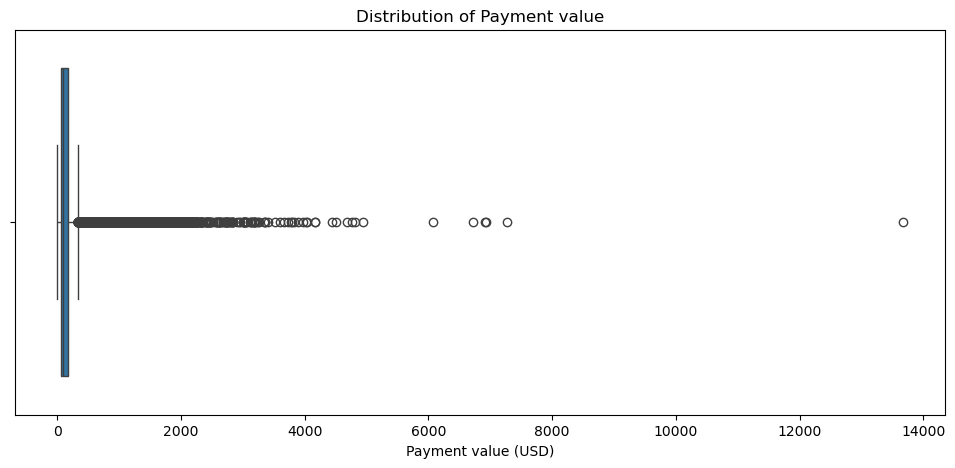

In [32]:
# Plot the distribution chart for the dataset to identify outlier
plt.figure(figsize=(12,5))
sns.boxplot(x=order_payment_cleaned['payment_value'])
plt.title('Distribution of Payment value')
plt.xlabel('Payment value (USD)')
plt.show()

In [33]:
# Examine the orders with payment value over 10000 USD 
outlier_value = order_payment_cleaned[(order_payment_cleaned['payment_value'] > 10000)]
display(outlier_value)

# Extract the order_id of outlier payment value and filter the order_item table 
outlier_value_id = outlier_value['order_id'].unique().tolist()

outlier_item = order_items_cleaned[order_items_cleaned['order_id'].isin(outlier_value_id)]
display(outlier_item)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
52107,03caa2c082116e1d31e67e9ae3700499,1,credit_card,1,13664.08


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
1647,03caa2c082116e1d31e67e9ae3700499,1,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01
1648,03caa2c082116e1d31e67e9ae3700499,2,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01
1649,03caa2c082116e1d31e67e9ae3700499,3,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01
1650,03caa2c082116e1d31e67e9ae3700499,4,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01
1651,03caa2c082116e1d31e67e9ae3700499,5,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01
1652,03caa2c082116e1d31e67e9ae3700499,6,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01
1653,03caa2c082116e1d31e67e9ae3700499,7,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01
1654,03caa2c082116e1d31e67e9ae3700499,8,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01


Since the payment value aligns with the sales figures from the order_item table, the outlier amount of 13,664.08 USD appears to be legitimate and does not need to be excluded.

##### 3.6 Clean the **Sellers table**

In [34]:
sellers_cleaned_df = sellers_df.copy()

# Remove '""' in the id column 
sellers_cleaned_df['seller_id'] = sellers_cleaned_df['seller_id'].str.replace('"','',regex=False)

# Remove '\r' from the string in seller_state
sellers_cleaned_df['seller_state'] = sellers_cleaned_df['seller_state'].str.replace('\r','',regex=False)

display(sellers_cleaned_df)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,0015a82c2db000af6aaaf3ae2ecb0532,28732,Fletcher,North Carolina
1,001cca7ae9ae17fb1caed9dfb1094831,70341,Belle Rose,Louisiana
2,001e6ad469a905060d959994f1b41e4f,60649,Chicago,Illinois
3,002100f778ceb8431b7a1020ff7ab48f,61072,Rockton,Illinois
4,003554e2dce176b5555353e4f3555ac8,57319,Bridgewater,South Dakota
...,...,...,...,...
3090,ffcfefa19b08742c5d315f2791395ee5,57566,Parmelee,South Dakota
3091,ffdd9f82b9a447f6f8d4b91554cc7dd3,28542,Camp Lejeune,North Carolina
3092,ffeee66ac5d5a62fe688b9d26f83f534,60503,Aurora,Illinois
3093,fffd5413c0700ac820c7069d66d98c89,85139,Maricopa,Arizona


#### 3.7 Clean the **Geolocation table** 

In [35]:
# Remove "\r" in the geolocation state 
geolocation_clean_df = geolocation_df.copy()
geolocation_clean_df['geolocation_state'] = geolocation_clean_df['geolocation_state'].str.replace('\r','',regex=False)

### 4. Data Transformation
This process create a surrogate key columns from the fact table in the schema and then subsquently, reduce the model size.

The schema after transformation:
- Dimension table : "Orders table", "product", "geolocation"
- Fact tables: "customers", "order items"

In [36]:
# Transform "Customer table" with new customer_key
customer_cleaned_examine = examine_data(customers_cleaned_df)
display(customer_cleaned_examine)


,rows_count,rows_with_nulls,unique,cardinality,with_nulls,null_%,1st_row,last_row,random_row,data_type
customer_id,99441,0,True,99441,False,0.0,00012a2ce6f8dcda20d059ce98491703,ffffe8b65bbe3087b653a978c870db99,15e25ffe745b83f124ec4d08b0af3667,object
customer_unique_id,99441,0,False,96096,False,0.0,248ffe10d632bebe4f7267f1f44844c9,736e6bfa0510aa5b878881a226a5fd89,1f7e585f18385c15b191a1f9dd84639a,object
customer_zip_code_prefix,99441,0,False,5841,False,0.0,41016,85305,64769,object
customer_city,99441,0,False,3781,False,0.0,Covington,Glendale,Mindenmines,object
customer_state,99441,0,False,25,False,0.0,Kentucky,Arizona,Missouri,object


In [37]:

dim_customers_df = customers_cleaned_df.copy()

# Create customer surrogate key customer_unique_sk for customer_unique_id
customer_unique_sk = dim_customers_df[['customer_unique_id']].drop_duplicates()
customer_unique_sk['index'] = range(1, len(customer_unique_sk)+1)
customer_unique_sk = customer_unique_sk.rename(columns={'index':'customer_unique_sk'})

# Create a dictionary to map the new unique customer surrogate key with the original key
map_customer_unique = pd.Series(customer_unique_sk['customer_unique_sk'].values,
                            customer_unique_sk['customer_unique_id']).to_dict()

# Add the customer_unique_sk to the dimension customer table by merging 
dim_customers_df = dim_customers_df.merge(customer_unique_sk,on='customer_unique_id',how='left')

# Create customer transaction surrogate key customer_sk for customer_id
dim_customers_df['customer_sk'] = range(1,len(dim_customers_df)+1)

# Create a dictionary to map the new surrogate key with the original key
map_customer_id = pd.Series(dim_customers_df['customer_sk'].values,
                            dim_customers_df['customer_id']).to_dict() 

# rearrange the columns
dim_customers_df = dim_customers_df[['customer_id','customer_sk', 'customer_unique_id','customer_unique_sk', 'customer_zip_code_prefix',
                                    'customer_city', 'customer_state']]

In [38]:
# Add the new customer_sk to the fact table 
dim_orders_df = orders_cleaned_df.copy()

dim_orders_df = dim_orders_df.merge(dim_customers_df[['customer_id','customer_sk']],on='customer_id', how ='left')
# Rearrange the columns for easy navigation 
dim_orders_df = dim_orders_df.drop(columns=['customer_id'])
dim_orders_df = dim_orders_df[['order_id', 'customer_sk', 'order_status', 'order_purchase_timestamp',
                                'order_approved_at', 'order_delivered_carrier_date',
                                'order_delivered_customer_date', 'order_estimated_delivery_date']]


In [39]:
# Create a surrogate key for the fact orders table order_id 
dim_orders_df = dim_orders_df.sort_values(by=['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date',
                                                'order_delivered_customer_date','order_estimated_delivery_date'],
                                            ascending = [True,True,True,True,True])

dim_orders_df = dim_orders_df.reset_index(drop=True)
dim_orders_df['order_sk'] = range(1, len(dim_orders_df) +1)

# Rearrange the columns for easy navigation 
dim_orders_df = dim_orders_df[['order_id', 'order_sk', 'customer_sk', 'order_status', 'order_purchase_timestamp',
                                'order_approved_at', 'order_delivered_carrier_date',
                                'order_delivered_customer_date', 'order_estimated_delivery_date']]



In [64]:
# Create surrogate keys for other dimenstion tables
# Product table 
dim_product_df = product_cleaned_df.copy()

dim_product_df['product_sk'] = range(1, len(dim_product_df)+1)
dim_product_df = dim_product_df[['product_id', 'product_sk','product_category_name', 'product_name_lenght',
                                'product_description_lenght', 'product_photos_qty', 'product_weight_g',
                                'product_length_cm', 'product_height_cm', 'product_width_cm']]



# Seller table 
dim_sellers_df = sellers_cleaned_df.copy()

dim_sellers_df['seller_sk'] = range(1, len(dim_sellers_df)+1)
dim_sellers_df = dim_sellers_df[['seller_id', 'seller_sk','seller_zip_code_prefix', 'seller_city', 'seller_state']]

In [41]:
# Add the new surrogate key to to link with other dimensions tables 
# Create a function to do so 
def order_sk_add(order_df,df_list):
    new_df_list = []
    for df in df_list:
        # Get the order_sk column
        merge_df = df.copy()
        merge_df = merge_df.merge(order_df,on='order_id',how='left')
        
        # Drop the orginal_id columns 
        merge_df = merge_df.drop(columns=['order_id'])
        # Get the list of columns and rearrange all of them 
        col_list = merge_df.columns.to_list()
        new_order = [col_list[-1]] + col_list[:-1]
        
        merge_df = merge_df[new_order]
        new_df_list.append(merge_df)
    return new_df_list
        

In [70]:
# Copy new order related fact tables
fct_order_items_df = order_items_cleaned.copy()
fct_order_payment_df = order_payment_cleaned.copy()
fct_order_review_df = order_review_cleaned.copy()

# Put them in a list 
order_tables = [fct_order_review_df,fct_order_items_df,fct_order_payment_df]

# Order_id and order_sk table 
order_id_sk = dim_orders_df[['order_id','order_sk']]

# Apply adding surrogate key function:
new_order_df_list = order_sk_add(order_id_sk,order_tables)

# Assign the df into variable individually 
fct_order_review_df = new_order_df_list[0]
fct_order_items_df = new_order_df_list[1]
fct_order_payment_df = new_order_df_list[2]

In [71]:
# Match the product_id and seller_id to their surrogate keys in the fact order_items table
fct_order_items_df = fct_order_items_df.merge(dim_product_df[['product_id','product_sk']],on='product_id',how='left')
fct_order_items_df = fct_order_items_df.merge(dim_sellers_df[['seller_id','seller_sk']],on='seller_id',how='left')

# Drop the orginal id columns and rearrange the columns for easy navigation
fct_order_items_df = fct_order_items_df.drop(columns=['product_id','seller_id'])
fct_order_items_df = fct_order_items_df[['order_sk', 'order_item_id', 'product_sk', 'seller_sk',
                                         'shipping_limit_date', 'price', 'freight_value']]

In [72]:
# Create surrogate keys for review id column
# Sort the df by review creation date from earliest
fct_order_review_df = fct_order_review_df.sort_values(by='review_creation_date',ascending=True)

# Create the surrogate key column
fct_order_review_df['review_sk'] = range(1,len(fct_order_review_df)+1)

# Rearrange the columns 
fct_order_review_df = fct_order_review_df[['order_sk','review_sk','review_id','review_score','review_comment_title','review_comment_message','review_creation_date','review_answer_timestamp']]


### 5. Update the analysis Database 

This part takes the cleaned and transformed tables and loads them into the database, setting up a complete schema with all the necessary relationships and keys for analysis.

In [73]:
# Create connection strings 
db_name_analysis = os.getenv("DB_ANALYTICS")

analysis_conn_string = f"mysql+mysqlconnector://{db_user}:{db_password}@{db_host}:{db_port}/{db_name_analysis}"

# Create the Engige
try: 
    analysis_engine = db.create_engine(analysis_conn_string)
    print(f"✅Connection to '{db_name_analysis}' successful.")
except Exception as e:
    print(f"Connection failed: {e}")

# Create a connection to the analysis scheme in the database 
analysis_conn = analysis_engine.connect()


✅Connection to 'db_olist_analytics' successful.


In [76]:
# Load the Dimension tables 

try:
    # Customers table 
    dim_customers_df.to_sql('dim_customers', con=analysis_conn, if_exists="replace",index="False")
    print("load 'dim_customers' successfullly")
    
    # Sellers table
    dim_sellers_df.to_sql('dim_sellers', con=analysis_conn, if_exists="replace",index="False")
    print("load 'dim_sellers' successfullly")
    
    # Products table 
    dim_product_df.to_sql('dim_products',con=analysis_conn,index=False, if_exists="replace")
    print("load 'dim_products' successfullly")
    
except Exception as e:
    print(f"❌ Error loading dimensions: {e}")

load 'dim_customers' successfullly
load 'dim_sellers' successfullly
load 'dim_products' successfullly


In [46]:
# Load the geolocation table with more than 2 million rows
try:
    #
    geolocation_clean_df.to_sql('dim_geolocation',con = analysis_engine, if_exists="replace",index=False,
                                chunksize=10000)
    print("✅ `dim_geolocation` loaded successfully (in chunks).")

except Exception as e:
    print(f"❌ Error loading geolocation: {e}")
    

✅ dim_geolocation loaded successfully (in chunks).


In [ ]:
# Load tables relating to orders 
try:
    # Load the orders table 
    dim_orders_df.to_sql('fct_orders',con= analysis_conn,if_exists= 'replace', index=False)
    print(f"load 'dim_orders_df' successfullly with {len(dim_orders_df)} rows")
    
    # Load the order review table
    fct_order_review_df.to_sql('fct_order_review',con= analysis_conn,if_exists= 'replace', index=False)
    print(f"load 'fct_order_riew_df' successfullly with {len(fct_order_review_df)} rows")
    
    # Load the order payment table
    fct_order_payment_df.to_sql('fct_order_payment',con= analysis_conn,if_exists= 'replace', index=False)
    print(f"load 'fct_order_payment_df' successfullly with {len(fct_order_payment_df)} rows")
    
    # Load the order review table
    fct_order_items_df.to_sql('fct_order_items',con= analysis_conn,if_exists= 'replace', index=False)
    print(f"load 'fct_order_items_df' successfullly with {len(fct_order_items_df)} rows")

except Exception as e:
    print(f"❌ Error loading geolocation: {e}")

load 'dim_orders_df' successfullly with 99428 rows
load 'fct_order_riew_df' successfullly with 98397 rows
load 'fct_order_payment_df' successfullly with 103873 rows
load 'fct_order_items_df' successfullly with 112642 rows


After load the tables to Analysis database for EDA and analysis, predetermine the keys and adjust the datatype 

In [55]:
# Pulls metadata from the INFORMATION_SCHEMA to show the data type and key status
meta_query ="""
    SELECT 
        TABLE_NAME, 
        COLUMN_NAME, 
        COLUMN_TYPE, 
        IS_NULLABLE,
        COLUMN_KEY  
    FROM INFORMATION_SCHEMA.COLUMNS 
    WHERE TABLE_SCHEMA = 'db_olist_analytics'
    ORDER BY TABLE_NAME, ORDINAL_POSITION;
    """


db_metadata = pd.read_sql(meta_query,analysis_conn)
display(db_metadata)

,TABLE_NAME,COLUMN_NAME,COLUMN_TYPE,IS_NULLABLE,COLUMN_KEY
0,dim_customers,False,bigint,YES,MUL
1,dim_customers,customer_id,varchar(60),YES,
2,dim_customers,customer_sk,bigint,NO,PRI
3,dim_customers,customer_unique_id,varchar(60),YES,
4,dim_customers,customer_unique_sk,bigint,YES,
5,dim_customers,customer_zip_code_prefix,text,YES,
6,dim_customers,customer_city,text,YES,
7,dim_customers,customer_state,text,YES,
8,dim_geolocation,geolocation_zip_code_prefix,text,YES,
9,dim_geolocation,geolocation_lat,double,YES,


In [ ]:
# Build the connection for ipython-sql
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_host = os.getenv("DB_HOST")
db_port = os.getenv("DB_PORT")
db_name_analytics = os.getenv("DB_ANALYTICS")


sql_analysis_conn_string = f"mysql+pymysql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name_analysis}"
%load_ext sql
%sql $sql_analysis_conn_string

print("✅ %%sql magic is now connected to 'db_olist_analytics'.")

In [ ]:
%%sql
USE db_olist_analytics;
-- Update the datatype TEXT to VARCHAR
ALTER TABLE dim_orders MODIFY order_id VARCHAR(60);
ALTER TABLE dim_customers MODIFY customer_id VARCHAR(60);
ALTER TABLE dim_customers MODIFY customer_unique_id VARCHAR(60)
ALTER TABLE dim_products MODIFY product_id VARCHAR(60);
ALTER TABLE dim_sellers MODIFY seller_id VARCHAR(60);
ALTER TABLE fct_order_review MODIFY review_id VARCHAR(60);
-- Set the Primary key to the dimenstion tables
ALTER TABLE dim_orders ADD PRIMARY KEY (order_sk);
ALTER TABLE dim_customers ADD PRIMARY KEY (customer_sk);
ALTER TABLE dim_products ADD PRIMARY KEY (product_sk);
ALTER TABLE dim_sellers ADD PRIMARY KEY (seller_sk)
-- Set Primary key to order reviews table 
ALTER TABLE fct_order_review ADD PRIMARY KEY (review_sk);
-- Set the Foreign keys to orders table
ALTER TABLE dim_orders ADD FOREIGN KEY (customer_sk) REFERENCE dim_customers(customer_sk);
-- Set the Foregin keys  to the fact tables
ALTER TABLE fct_order_review ADD FOREIGN KEY (order_sk) REFERENCES dim_orders(order_sk);
ALTER TABLE fct_order_payment ADDF FOREIGN KEY (order_sk) REFERENCES dim_orders(order_sk);
-- Set the Foreign keys to order items table 
ALTER TABLE fct_order_items ADD FOREIGN KEY (order_sk) REFERENCES dim_orders(order_sk);
ALTER TABLE fct_order_items ADD FOREIGN KEY (seller_sk) REFERENCES dim_sellers(seller_sk);
ALTER TABLE fct_order_items ADD FOREIGN KEY (product_sk) REFERENCES dim_products(product_sk);
-- Drop the "False" index column 
ALTER TABLE dim_customers DROP COLUMN `False`;
ALTER TABLE dim_sellers DROP COLUMN `False`;
